![image](https://app.lucidchart.com/publicSegments/view/104d6877-b1c0-4700-b91f-50aa1f7092e7/image.png)

In [1]:
import pandas as pd
pd.options.plotting.backend = "matplotlib"

In [2]:
eth_locked_df = pd.read_csv('raw_files/dai_weth.csv')
eth_locked_df.set_index(pd.to_datetime(eth_locked_df['__timestamp']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
eth_locked_df.sort_index(inplace=True)
original_columns = list(eth_locked_df.columns)

eth_locked_df['Q(eth_locked)'] = eth_locked_df['Locked Amount']
eth_locked_df.drop(columns=original_columns, inplace=True)
eth_locked_df

,Q(eth_locked)
__timestamp,
2017-12-18,2425.662000
2017-12-19,6240.431314
2017-12-20,14183.070621
2017-12-21,15644.732690
2017-12-22,18830.844186
...,...
2020-05-08,216796.370398
2020-05-09,213554.344456
2020-05-10,211318.587678


In [3]:
dai_mints_burns = pd.read_csv('raw_files/dai_minted_burnt.csv')

dai_mints_burns.set_index(pd.to_datetime(dai_mints_burns['__timestamp']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
dai_mints_burns.sort_index(inplace=True)
original_columns = list(dai_mints_burns.columns)
dai_mints_burns['u_3'] = dai_mints_burns['Minted DAI'].diff().fillna(dai_mints_burns['Minted DAI'])
dai_mints_burns['b_2 + u_4'] = dai_mints_burns['Burnt DAI'].diff().fillna(dai_mints_burns['Burnt DAI'])
dai_mints_burns.drop(columns=original_columns, inplace=True)
dai_mints_burns

,u_3,b_2 + u_4
__timestamp,,
2017-12-18,5.953420e+05,45.943840
2017-12-19,1.379832e+06,35394.482980
2017-12-20,2.676383e+06,502251.750000
2017-12-21,8.053550e+05,49782.711992
2017-12-22,3.145512e+05,747453.127687
...,...,...
2020-08-01,1.786804e+02,11524.007450
2020-08-02,1.091655e+04,10646.097875
2020-08-14,9.647781e+02,12898.813466


In [4]:
wipes_shuts = pd.read_json('raw_files/dune_data.json')
wipes_shuts.set_index(pd.to_datetime(wipes_shuts['date_trunc']).dt.date, 
                          verify_integrity=True,
                          inplace=True                          
                         )
original_columns = list(wipes_shuts.columns)
wipes_shuts['u_4'] = wipes_shuts['debt_payment']
wipes_shuts['v'] = wipes_shuts['usd_fee_paid']
wipes_shuts.drop(columns=original_columns, inplace=True)
wipes_shuts

,u_4,v
date_trunc,,
2017-12-18,1.000000e+01,0.000006
2017-12-19,3.536748e+04,0.455885
2017-12-20,5.014128e+05,0.178879
2017-12-21,4.978271e+04,1.158909
2017-12-22,7.239153e+05,19.756468
...,...,...
2019-09-26,1.515115e+06,64257.311824
2019-09-27,6.366783e+05,7214.430099
2019-09-28,1.452062e+05,492.589362


In [5]:
pd.read_csv('raw_files/DAIETH_data.csv').head()

,date,CDP opened,Mean of CDP values (in ETH),Median of CDP values (in ETH),ETH Price,DAI Price,Collateralization Ratio,DAI Transaction Volume,ETH Transaction Volume,DAI Velocity,...,DAI OpenPrice,ETH ClosePrice,ETH HighPrice,ETH LowPrice,ETH OpenPrice,Amount of Bites,"Volume of Bites, DAI",DAI Exchange Flow,ETH Exchange Flow,Stability Fee
0,2017-12-18,34,302.437500,150.000000,736.004090,1.017605,3.111753,3.940487e+06,9.118394e+06,6.619373,...,0.0,794.645,803.928,689.231,721.732,2,40.402166,0.0,736.004090,0.5
1,2017-12-19,48,322.165833,3.000000,832.236972,1.003376,2.596342,8.238559e+06,1.216285e+07,5.783800,...,0.0,826.823,881.944,785.342,793.901,1,31.049988,0.0,832.236972,0.5
2,2017-12-20,19,562.073425,5.051350,810.287507,1.012972,2.701200,7.074254e+06,1.365837e+07,2.730301,...,0.0,819.086,845.062,756.004,827.516,2,984.431900,0.0,810.287507,0.5
3,2017-12-21,19,516.052368,5.999881,837.231080,1.025738,2.640305,4.517757e+06,1.376215e+07,4.382941,...,0.0,821.063,880.543,792.689,820.236,0,0.000000,0.0,837.231080,0.5
4,2017-12-22,20,455.274048,6.041323,689.014990,0.972228,2.793268,2.129117e+07,1.500169e+07,10.231087,...,0.0,674.860,827.683,543.762,822.643,14,29173.486409,0.0,689.014990,0.5


In [6]:
eth_price = pd.read_csv('raw_files/DAIETH_data.csv', usecols=['date','ETH Price', 'Stability Fee', 'DAI Price'])
eth_price.set_index(pd.to_datetime(eth_price['date']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
eth_price.sort_index(inplace=True)
original_columns = list(eth_price.columns)
eth_price['rho_star(eth_price)'] = eth_price['ETH Price']
eth_price['beta(stability_fee)'] = eth_price['Stability Fee']
eth_price['p(dai_price)'] = eth_price['DAI Price']
eth_price.drop(columns=original_columns, inplace=True)
eth_price

,rho_star(eth_price),beta(stability_fee),p(dai_price)
date,,,
2017-12-18,736.004090,0.5,1.017605
2017-12-19,832.236972,0.5,1.003376
2017-12-20,810.287507,0.5,1.012972
2017-12-21,837.231080,0.5,1.025738
2017-12-22,689.014990,0.5,0.972228
...,...,...,...
2019-09-26,167.637314,12.5,1.021405
2019-09-27,167.347085,12.5,1.007346
2019-09-28,174.289775,12.5,1.011006


In [7]:
debt_price_df = eth_price.join(eth_locked_df).join(dai_mints_burns).join(wipes_shuts)
debt_price_df['u_4'].fillna(0, inplace=True)
debt_price_df['v'].fillna(0, inplace=True)

In [8]:
debt_price_df['b_2'] = debt_price_df['b_2 + u_4'] - debt_price_df['u_4']
debt_price_df[debt_price_df['b_2']<-0.001]

,rho_star(eth_price),beta(stability_fee),p(dai_price),Q(eth_locked),u_3,b_2 + u_4,u_4,v,b_2
date,,,,,,,,,
2019-03-27,139.144023,7.5,0.991167,2.174332e+06,1.322572e+05,3.076867e+05,3.077473e+05,1281.057348,-60.606091
2019-04-01,142.012896,7.5,0.964465,2.171342e+06,7.478807e+05,3.881296e+05,3.882548e+05,777.946921,-125.156193
2019-04-02,152.791939,7.5,0.974243,2.175015e+06,1.576052e+06,4.013269e+06,4.014125e+06,24861.857531,-855.980481
2019-04-04,161.092536,7.5,0.973003,2.168093e+06,1.842784e+06,6.587407e+05,6.592339e+05,2262.605607,-493.153802
2019-04-05,163.085352,7.5,0.963762,2.184325e+06,1.662900e+06,2.696518e+05,2.696547e+05,1137.729074,-2.901397
2019-04-07,168.661736,7.5,0.961275,2.202064e+06,1.926685e+06,4.305837e+05,4.305926e+05,1668.007402,-8.879735
2019-04-08,179.781012,7.5,0.956671,2.199845e+06,2.167299e+06,1.455614e+06,1.455638e+06,4149.717045,-23.851324


In [9]:
debt_price_df['b_2'] = debt_price_df['b_2'].apply(lambda x: max(0,x))
debt_price_df[debt_price_df['b_2']<0]

,rho_star(eth_price),beta(stability_fee),p(dai_price),Q(eth_locked),u_3,b_2 + u_4,u_4,v,b_2
date,,,,,,,,,


In [10]:
debt_price_df['b_3'] = debt_price_df['b_2'] * debt_price_df['v'] / debt_price_df['u_4']
debt_price_df['b_3'].fillna(0, inplace=True)
debt_price_df

,rho_star(eth_price),beta(stability_fee),p(dai_price),Q(eth_locked),u_3,b_2 + u_4,u_4,v,b_2,b_3
date,,,,,,,,,,
2017-12-18,736.004090,0.5,1.017605,2.425662e+03,5.953420e+05,4.594384e+01,1.000000e+01,0.000006,35.943840,0.000023
2017-12-19,832.236972,0.5,1.003376,6.240431e+03,1.379832e+06,3.539448e+04,3.536748e+04,0.455885,27.000000,0.000348
2017-12-20,810.287507,0.5,1.012972,1.418307e+04,2.676383e+06,5.022518e+05,5.014128e+05,0.178879,839.000000,0.000299
2017-12-21,837.231080,0.5,1.025738,1.564473e+04,8.053550e+05,4.978271e+04,4.978271e+04,1.158909,0.000000,0.000000
2017-12-22,689.014990,0.5,0.972228,1.883084e+04,3.145512e+05,7.474531e+05,7.239153e+05,19.756468,23537.818000,0.642374
...,...,...,...,...,...,...,...,...,...,...
2019-09-26,167.637314,12.5,1.021405,1.525944e+06,8.079170e+05,1.585480e+06,1.515115e+06,64257.311824,70364.380268,2984.212338
2019-09-27,167.347085,12.5,1.007346,1.529959e+06,6.087607e+05,6.367461e+05,6.366783e+05,7214.430099,67.790257,0.768156
2019-09-28,174.289775,12.5,1.011006,1.528450e+06,2.251956e+05,1.452312e+05,1.452062e+05,492.589362,25.000000,0.084809


In [11]:
debt_price_df['D_1'] = debt_price_df['u_3'].cumsum() - debt_price_df['u_4'].cumsum() - debt_price_df['b_2'].cumsum()
debt_price_df

,rho_star(eth_price),beta(stability_fee),p(dai_price),Q(eth_locked),u_3,b_2 + u_4,u_4,v,b_2,b_3,D_1
date,,,,,,,,,,,
2017-12-18,736.004090,0.5,1.017605,2.425662e+03,5.953420e+05,4.594384e+01,1.000000e+01,0.000006,35.943840,0.000023,5.952961e+05
2017-12-19,832.236972,0.5,1.003376,6.240431e+03,1.379832e+06,3.539448e+04,3.536748e+04,0.455885,27.000000,0.000348,1.939733e+06
2017-12-20,810.287507,0.5,1.012972,1.418307e+04,2.676383e+06,5.022518e+05,5.014128e+05,0.178879,839.000000,0.000299,4.113865e+06
2017-12-21,837.231080,0.5,1.025738,1.564473e+04,8.053550e+05,4.978271e+04,4.978271e+04,1.158909,0.000000,0.000000,4.869437e+06
2017-12-22,689.014990,0.5,0.972228,1.883084e+04,3.145512e+05,7.474531e+05,7.239153e+05,19.756468,23537.818000,0.642374,4.436535e+06
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,167.637314,12.5,1.021405,1.525944e+06,8.079170e+05,1.585480e+06,1.515115e+06,64257.311824,70364.380268,2984.212338,7.957442e+07
2019-09-27,167.347085,12.5,1.007346,1.529959e+06,6.087607e+05,6.367461e+05,6.366783e+05,7214.430099,67.790257,0.768156,7.954644e+07
2019-09-28,174.289775,12.5,1.011006,1.528450e+06,2.251956e+05,1.452312e+05,1.452062e+05,492.589362,25.000000,0.084809,7.962640e+07


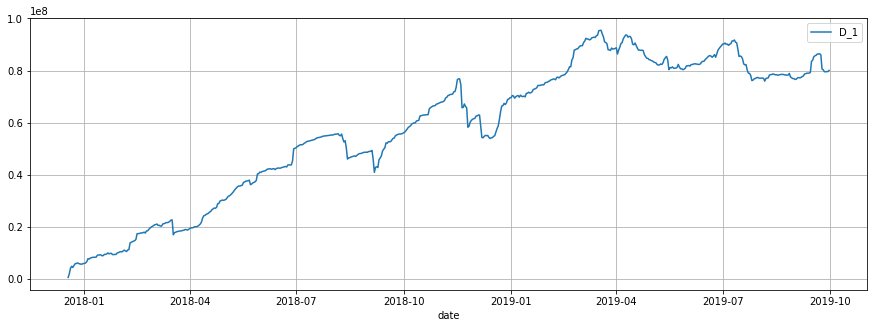

In [12]:
debt_price_df.plot(y = 'D_1', figsize=(15,5), grid=True)

In [13]:
debt_price_df.columns

Index(['rho_star(eth_price)', 'beta(stability_fee)', 'p(dai_price)',
       'Q(eth_locked)', 'u_3', 'b_2 + u_4', 'u_4', 'v', 'b_2', 'b_3', 'D_1'],
      dtype='object')

In [14]:
import numpy as np
d2 = [0]
for i,r in debt_price_df.iterrows():
    if i==debt_price_df.index[0]:
        continue
    beta = r['beta(stability_fee)']/100
    delta_t = 1/365
    d_1 = r['D_1']
    d_2 = d2[-1]
    v = r['v']
    b_3 = r['b_3']
    new_d2 = d_2 + ((1+beta)**delta_t - 1) * (d_1 + d_2) - v - b_3
    d2.append(new_d2)
debt_price_df['D_2'] = d2
debt_price_df['D'] = debt_price_df['D_1'] + debt_price_df['D_2']
debt_price_df['C_star'] = debt_price_df['Q(eth_locked)'] * debt_price_df['rho_star(eth_price)']
debt_price_df['p_star'] = 1

def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a
debt_price_df['ema_p(dai_price)'] = pd.Series(ExpMovingAverage(debt_price_df['p(dai_price)'], 10), index=debt_price_df.index)

# Relative Strength Index
# https://finpy.org/2019-07-17-exponential-moving-average-relative-strength-index-using-python/
def RSI(close, period=14):
    # Wilder's RSI
    delta = close.diff() 
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    # Calculate the exponential moving averages (EWMA)
    roll_up = up.ewm(com=period - 1, adjust=False).mean()
    roll_down = down.ewm(com=period - 1, adjust=False).mean().abs()
    # Calculate RS based on exponential moving average (EWMA)
    rs = roll_up / roll_down   # relative strength =  average gain/average loss
    rsi = 100-(100/(1+rs))
    return rsi


debt_price_df['eth_price_RSI'] = RSI(debt_price_df['rho_star(eth_price)'])

# Debt Price Heuristic - option 1

Debt price: $\hat{p}$  
Define a "system level balance sheet" $V(\mathcal{X},\hat{p})$   
* $V(\mathcal{X},\hat{p}) = assets - liabilities$  
    * $assets = Q\rho^* + D_1\hat{p}$  
    * $liabilities = D_1\hat{p} + D_2\hat{p}$  
* $V(\mathcal{X},\hat{p}) = Q\rho^* + D_1\hat{p} - D_1\hat{p} - D_2\hat{p}$  
* $V(\mathcal{X},\hat{p}) = Q\rho^* - D_2\hat{p}$  

Let's assume $V_{t+1}=V_t$
* $Q_{t+1}\rho^*_{t+1} - D_{2;t+1}\hat{p}_{t+1} = Q_{t}\rho^*_{t} - D_{2;t}\hat{p}_{t}$

Solve for $\hat{p}_{t+1}$
* $D_{2;t+1}\hat{p}_{t+1} = Q_{t+1}\rho^*_{t+1} - Q_{t}\rho^*_{t} + D_{2;t}\hat{p}_{t}$
* $D_{2;t+1}\hat{p}_{t+1} = C^*_{t+1} - C^*_{t} + D_{2;t}\hat{p}_{t}$
* $\hat{p}_{t+1} = \frac{C^*_{t+1} - C^*_{t} + D_{2;t}\hat{p}_{t}}{D_{2;t+1}}$
* $\hat{p}_{t+1} = \frac{\Delta{C^*} + D_{2;t}\hat{p}_{t}}{D_{2;t+1}}$

Assume $\hat{p}_0 = p^*_0$

In [15]:
p_star_0 = debt_price_df.iloc[0]['p_star']
p_hat_0 = p_star_0
C_star_0 = debt_price_df.iloc[0]['C_star']
D_1_0 = debt_price_df.iloc[0]['D_1']
D_2_0 = debt_price_df.iloc[0]['D_2']

V = C_star_0 - D_2_0 * p_hat_0

V

1785297.1536313752

For practical purposes (we want to compute $\hat{p}$ using trivial pandas Series operations), let's reorganize the terms of the equations in a different way
* $Q_{t+1}\rho^*_{t+1} - D_{2;t+1}\hat{p}_{t+1} = V_0$
* $D_{2;t+1}\hat{p}_{t+1} = Q_{t+1}\rho^*_{t+1} - V_0$
* $\hat{p}_{t+1} = \frac{Q_{t+1}\rho^*_{t+1} - V_0}{D_{2;t+1}}$

In [16]:
C_star = debt_price_df['C_star']
D_2 = debt_price_df['D_2']

p_hat = (C_star - V) / D_2

debt_price_df['debt_price_option_1'] = p_hat

# Debt Price Heuristic

Debt price: $\hat{p}$  
Define a "system level balance sheet" $V(\mathcal{X},\hat{p})$   

$V(\mathcal{X},\hat{p})$   
* $V(\mathcal{X},\hat{p}) = assets - liabilities$  
    * $assets = Q\rho^* + D_1\hat{p}$  
    * $liabilities = D_1 p^* + D_2p^*$  
* $V(\mathcal{X},\hat{p}) = Q\rho^* + D_1 (\hat p - p^*) - D_2p^*$  

Let's assume $V_{t+1}=V_t$
$$Q_{t+1}\rho_{t+1}^* + D_{1; t+1} (\hat p_{t+1} - p_{t+1}^*) - D_{2:t+1}p^*_{t+1}= Q_t\rho^*_t + D_{1;t} (\hat p_t - p^*_t) - D_{2;t}p_t^*$$

$$\hat p_{t+1} = p^*_{t+1} + \frac{Q_tp_t^*-Q_{t+1}\rho_{t+1}^*+D_{2;t+1} p^*_{t+1}-D_{2;t} p^*_{t}+ D_{1; t} (\hat p_{t} - p_{t}^*)}{D_{1;t+1}}$$

Zargham's comment: while this turns out to be a bit more complex, one thing i like about it is that it results in a debt price described as a correction to the redemption price, which i think will help when we look to apply the model \[beyond\] the DAI system.

In [17]:
p_star_0 = debt_price_df.iloc[0]['p_star']
p_hat_0 = p_star_0
C_star_0 = debt_price_df.iloc[0]['C_star']
D_1_0 = debt_price_df.iloc[0]['D_1']
D_2_0 = debt_price_df.iloc[0]['D_2']

V = C_star_0 + D_1_0 * (p_hat_0 - p_star_0) - D_2_0 * p_hat_0
V

1785297.1536313752

For practical purposes (we want to compute $\hat{p}$ using trivial pandas Series operations), let's reorganize the terms of the equations in a different way
* $Q_{t+1}\rho_{t+1}^* + D_{1; t+1} (\hat p_{t+1} - p_{t+1}^*) - D_{2:t+1}p^*_{t+1}=V_0$
* $D_{1; t+1} (\hat p_{t+1} - p_{t+1}^*) = V_0 - Q_{t+1}\rho_{t+1}^* + D_{2:t+1}p^*_{t+1}$
* $\hat p_{t+1} - p_{t+1}^* = \frac{V_0 - Q_{t+1}\rho_{t+1}^* + D_{2:t+1}p^*_{t+1}}{D_{1; t+1}}$
* $\hat p_{t+1} = \frac{V_0 - Q_{t+1}\rho_{t+1}^* + D_{2:t+1}p^*_{t+1}}{D_{1; t+1}} + p_{t+1}^*$

In [18]:
p_star = debt_price_df['p_star']
C_star = debt_price_df['C_star']
D_1 = debt_price_df['D_1']
D_2 = debt_price_df['D_2']

p_hat = (V - C_star + D_2 * p_star) / D_1 + p_star

debt_price_df['debt_price_option_2'] = p_hat

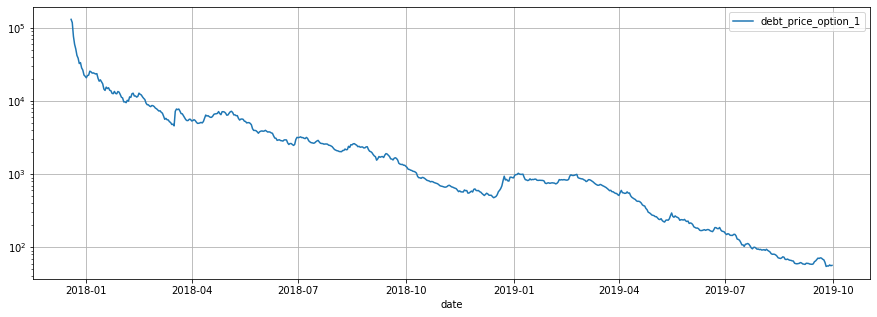

In [19]:
debt_price_df.plot(y='debt_price_option_1', logy=True, figsize=(15,5), grid=True)

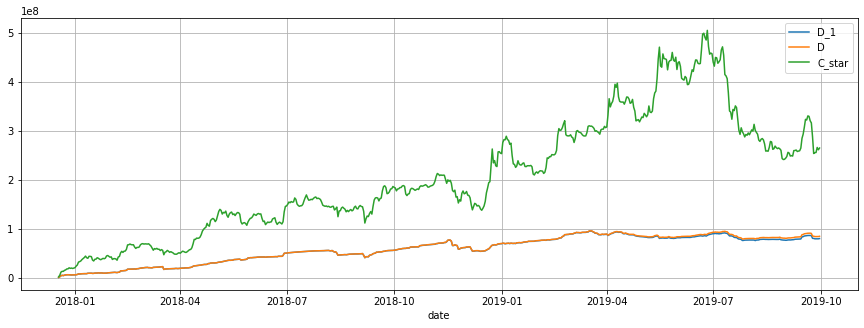

In [20]:
debt_price_df.plot(y = ['D_1','D','C_star'], figsize=(15,5), grid=True)

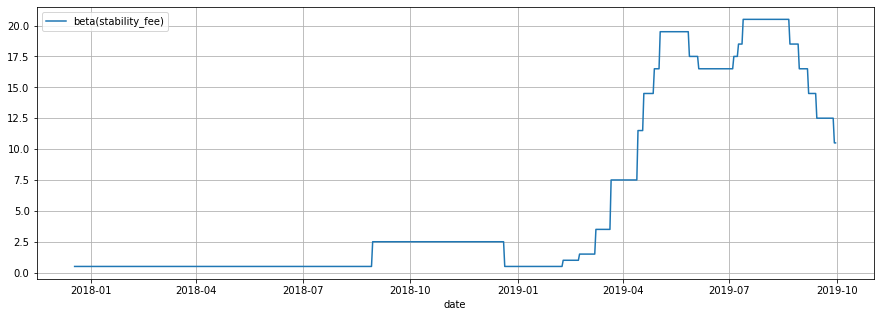

In [21]:
debt_price_df.plot(y = ['beta(stability_fee)'], figsize=(15,5), grid=True)

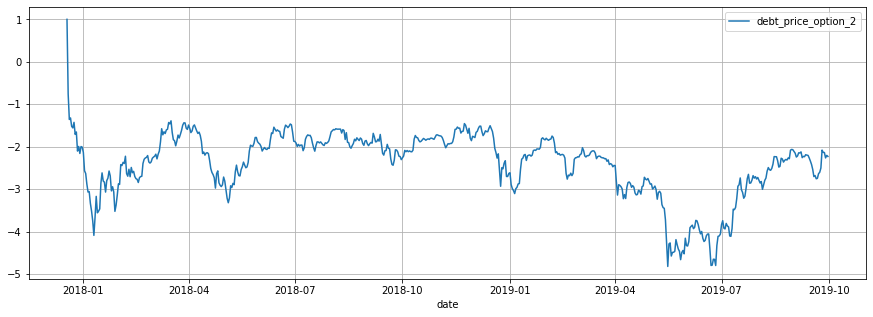

In [22]:
debt_price_df.plot(y='debt_price_option_2', figsize=(15,5), grid=True)

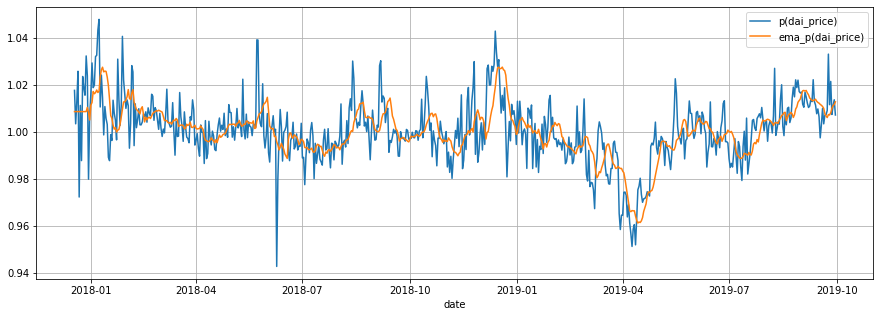

In [23]:
debt_price_df.plot(y = ['p(dai_price)', 'ema_p(dai_price)'], figsize=(15,5), grid=True)

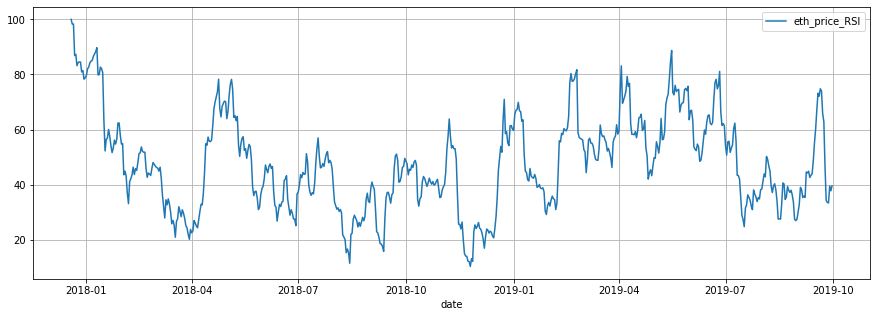

In [24]:
debt_price_df.plot(y = ['eth_price_RSI'], figsize=(15,5), grid=True)

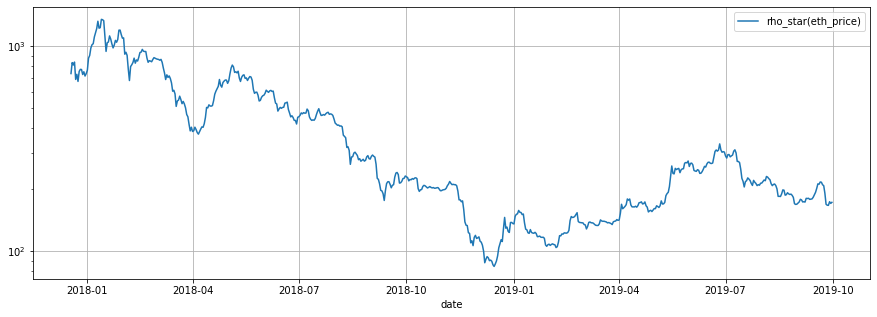

In [25]:
debt_price_df.plot(y = ['rho_star(eth_price)'], figsize=(15,5), grid=True, logy=True)

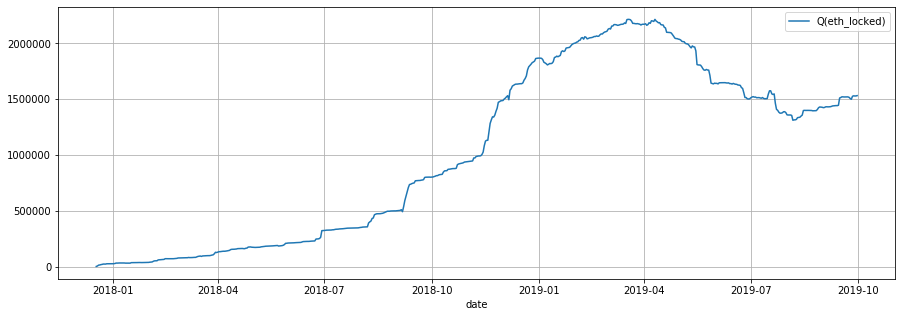

In [26]:
debt_price_df.plot(y = ['Q(eth_locked)'], figsize=(15,5), grid=True)